In [22]:
import numpy as np
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv(r'C:\Users\uzmap\Documents\GitHub\ForEx\all_data.csv')
df.drop('Unnamed: 0', axis =1, inplace = True)
df.head()

,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair
0,2014-11-20,61.870,61.923,61.45,61.923,USD/INR
1,2014-11-23,61.680,61.958,61.52,61.760,USD/INR
2,2014-11-24,61.853,62.028,61.77,61.853,USD/INR
3,2014-11-25,61.840,61.900,61.73,61.840,USD/INR
4,2014-11-26,61.728,61.908,61.66,61.788,USD/INR


In [24]:
usdinrSarima = df.loc[df['Currency Pair']=='USD/INR']
usdinrSarima.reset_index(drop=True,inplace=True)

In [25]:
usdinrSarima['Date']= pd.to_datetime(usdinrSarima['Date'])

In [26]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

for i in usdinrSarima.columns : 
  if i!='Currency Pair' :
    print("ADFuller test for column : ",i)
    check_stationarity(usdinrSarima[i])

ADFuller test for column :  Date
ADF Statistic: 1.064453
p-value: 0.994902
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Open_price
ADF Statistic: -0.677480
p-value: 0.852497
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_high
ADF Statistic: -0.754738
p-value: 0.832057
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_low
ADF Statistic: -1.526129
p-value: 0.520548
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test fo

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_column(data, column, period=7):
    """
    Deseasonalizes a column by decomposing it into trend, seasonality, and residual components.
    
    Parameters:
    - data (pd.DataFrame): The DataFrame containing the time series data.
    - column (str): The name of the column to deseasonalize.
    - period (int): The periodicity of the data (e.g., 7 for weekly seasonality).
    
    Returns:
    - pd.Series: The deseasonalized version of the column.
    """
    # Decompose the column
    decomposition = seasonal_decompose(data[column], model='additive', period=period, extrapolate_trend='freq')
    
    # Extract the residual component as deseasonalized data
    deseasonalized = data[column] - decomposition.seasonal
    
    return deseasonalized

# Identify non-stationary columns
non_stationary_columns = ['Day_high', 'Day_low', 'Open_price']

# Create deseasonalized columns
for col in non_stationary_columns:
    deseasonalized_col = deseasonalize_column(usdinrSarima, col, period=14)  # Adjust the period as needed
    usdinrSarima[f'Deseasonalized_{col}'] = deseasonalized_col


In [28]:
import swing_technical_indicators

usdinrSarima['EMA_50'] = swing_technical_indicators.calculate_100ema(usdinrSarima, 'Closing_price', 50)
usdinrSarima['EMA_100'] = swing_technical_indicators.calculate_100ema(usdinrSarima, 'Closing_price', 100)
usdinrSarima['EMA_200'] = swing_technical_indicators.calculate_200ema(usdinrSarima, 'Closing_price', 200)

In [29]:
usdinrSarima['RSI'] = swing_technical_indicators.calculate_rsi(usdinrSarima,'Closing_price',21)
usdinrSarima_macd = swing_technical_indicators.calculate_macd(usdinrSarima, column_name='Closing_price', short_period=12, long_period=26, signal_period=9)

for i in usdinrSarima_macd.columns:

    usdinrSarima[f"{i}"] = usdinrSarima_macd[f'{i}']
bollinger_data = swing_technical_indicators.calculate_bollinger_bands(usdinrSarima['Closing_price'])

usdinrSarima = usdinrSarima.join(bollinger_data)
usdinrSarima.drop('Price',axis=1, inplace=True)

In [30]:
usdinrSarima.head()

,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,2014-11-20,61.870,61.923,61.45,61.923,USD/INR,61.933927,61.436177,61.868257,61.923000,61.923000,61.923000,0.0,0.000000,0.000000,0.000000,62.1765,63.360705,60.992295
1,2014-11-23,61.680,61.958,61.52,61.760,USD/INR,61.978866,61.541641,61.697334,61.916608,61.919772,61.921378,0.0,-0.013003,-0.002601,-0.010402,62.1765,63.360705,60.992295
2,2014-11-24,61.853,62.028,61.77,61.853,USD/INR,62.057457,61.786277,61.890651,61.914113,61.918450,61.920698,0.0,-0.015623,-0.005205,-0.010418,62.1765,63.360705,60.992295
3,2014-11-25,61.840,61.900,61.73,61.840,USD/INR,61.917248,61.739567,61.869127,61.911207,61.916897,61.919895,0.0,-0.018535,-0.007871,-0.010664,62.1765,63.360705,60.992295
4,2014-11-26,61.728,61.908,61.66,61.788,USD/INR,61.921666,61.660142,61.729656,61.906375,61.914344,61.918582,0.0,-0.024754,-0.011248,-0.013506,62.1765,63.360705,60.992295


In [31]:
X = usdinrSarima.drop(['Date','Open_price','Day_high','Day_low','Closing_price','Currency Pair'],axis=1)
y =usdinrSarima['Closing_price']
columns = X.columns

In [32]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)
X= pd.DataFrame(X,columns = columns)

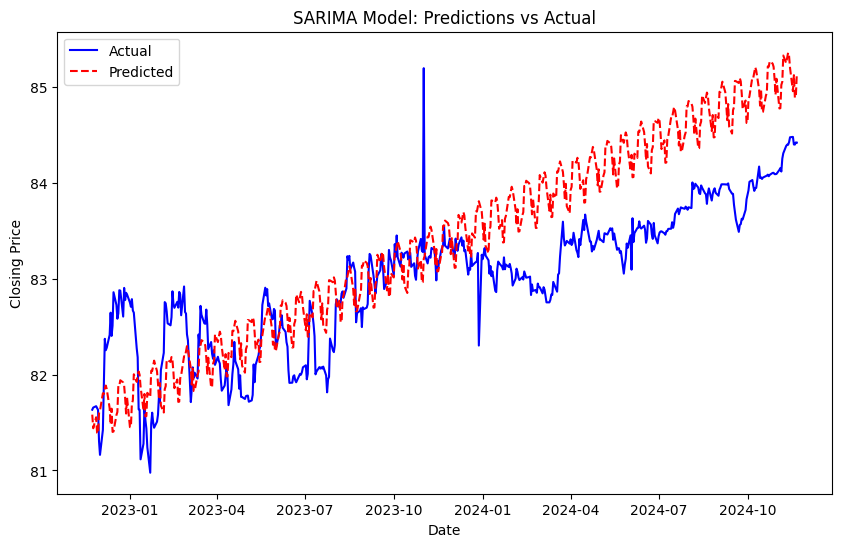

                                     SARIMAX Results                                      
Dep. Variable:                      Closing_price   No. Observations:                 2086
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -624.364
Date:                            Tue, 26 Nov 2024   AIC                           1260.728
Time:                                    10:43:19   BIC                           1294.508
Sample:                                         0   HQIC                          1273.113
                                           - 2086                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Date_numeric -4.405e-07   1.61e-07     -2.736      0.006   -7.56e-07   -1.25e-07
ar.L1            0.5234      

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assume jpy_inr is your DataFrame with the 'Date' column and target 'Closing_price'
# Ensure 'Date' is in datetime format
usdinrSarima['Date'] = pd.to_datetime(usdinrSarima['Date'])

# Convert 'Date' to numeric (timestamp)
usdinrSarima['Date_numeric'] = usdinrSarima['Date'].apply(lambda x: x.timestamp())

# Set the target column
target = 'Closing_price'

# Train-Test Split (80%-20%)
train_size = int(len(usdinrSarima) * 0.8)
train, test = usdinrSarima[:train_size], usdinrSarima[train_size:]

# SARIMA Model: SARIMAX for seasonal data
sarima_model = SARIMAX(train[target], 
                       order=(1, 1, 1),  # AR, I, MA order
                       seasonal_order=(1, 1, 1, 12),  # Seasonal order
                       exog=train[['Date_numeric']],  # Include 'Date_numeric' as an exogenous variable
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the model
sarima_fit = sarima_model.fit()

# Make predictions
predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=test[['Date_numeric']])

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(test['Date'], test[target], label="Actual", color='blue')
plt.plot(test['Date'], predictions, label="Predicted", color='red', linestyle="--")
plt.legend()
plt.title("SARIMA Model: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

# Optional: Print out model diagnostics
print(sarima_fit.summary())


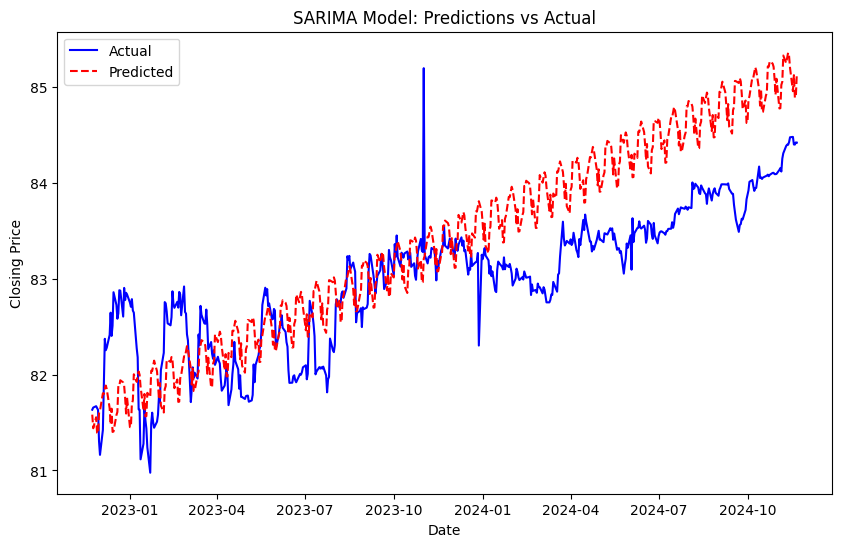

Root Mean Squared Error (RMSE): 0.7002


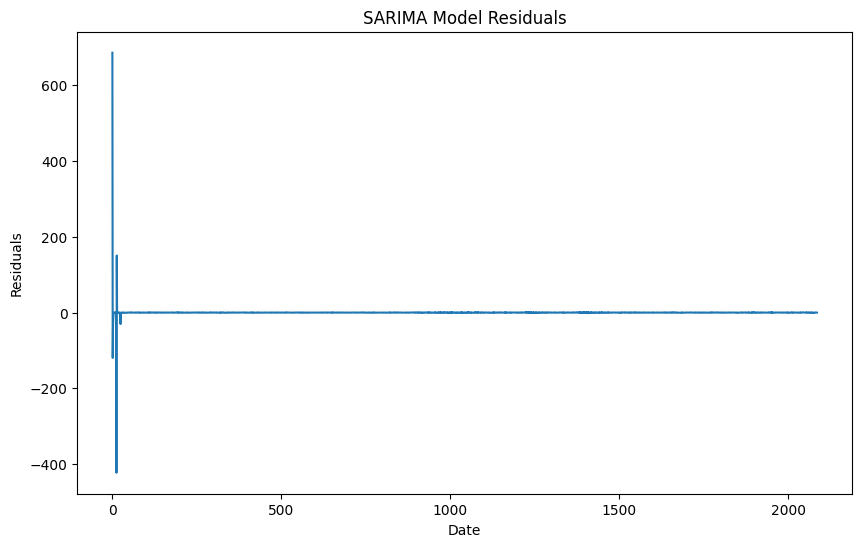

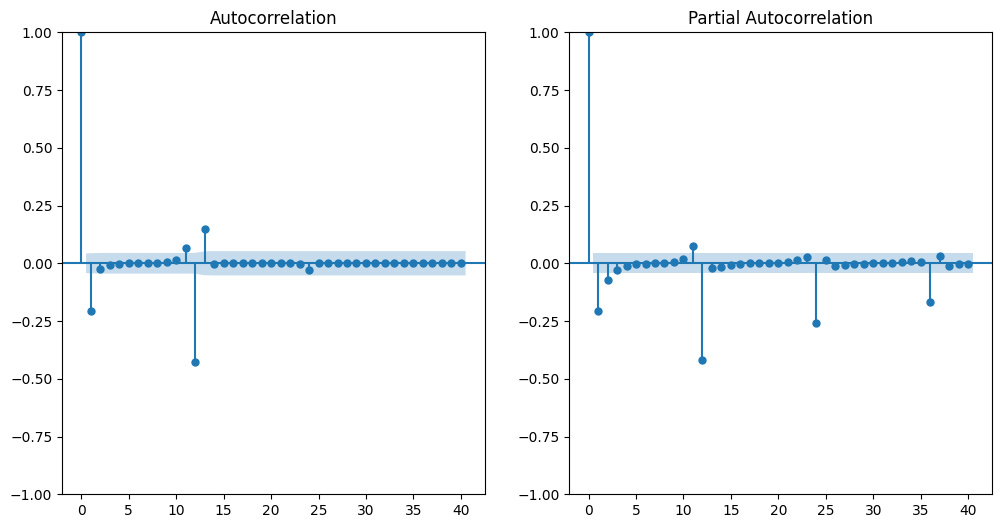

                                     SARIMAX Results                                      
Dep. Variable:                      Closing_price   No. Observations:                 2086
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -624.364
Date:                            Tue, 26 Nov 2024   AIC                           1260.728
Time:                                    10:43:24   BIC                           1294.508
Sample:                                         0   HQIC                          1273.113
                                           - 2086                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Date_numeric -4.405e-07   1.61e-07     -2.736      0.006   -7.56e-07   -1.25e-07
ar.L1            0.5234      

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# Ensure 'Date' is in datetime format
usdinrSarima['Date'] = pd.to_datetime(usdinrSarima['Date'])

# Convert 'Date' to numeric (timestamp)
usdinrSarima['Date_numeric'] = usdinrSarima['Date'].apply(lambda x: x.timestamp())

# Define the target column
target = 'Closing_price'

# Train-Test Split (80%-20%)
train_size = int(len(usdinrSarima) * 0.8)
train, test = usdinrSarima[:train_size], usdinrSarima[train_size:]

# Hyperparameters for SARIMA
p, d, q = 1, 1, 1  # AR, I, MA order
P, D, Q, S = 1, 1, 1, 12  # Seasonal AR, I, MA order, and period

# SARIMA Model: SARIMAX for seasonal data
sarima_model = SARIMAX(train[target], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, S), 
                       exog=train[['Date_numeric']],  # Include 'Date_numeric' as an exogenous variable
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the model
sarima_fit = sarima_model.fit()

# Make predictions
predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=test[['Date_numeric']])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], test[target], label="Actual", color='blue')
plt.plot(test['Date'], predictions, label="Predicted", color='red', linestyle="--")
plt.legend()
plt.title("SARIMA Model: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

# Evaluate the model with RMSE
rmse_val = rmse(test[target], predictions)
print(f"Root Mean Squared Error (RMSE): {rmse_val:.4f}")

# Plot residuals to check for patterns
residuals = sarima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("SARIMA Model Residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Plot ACF and PACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.show()

# Optional: Print out model diagnostics
print(sarima_fit.summary())

In [35]:
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# Define the target column
target = 'Closing_price'

# Train-Test Split (80%-20%)
train_size = int(len(usdinrSarima) * 0.8)
train, test = usdinrSarima[:train_size], usdinrSarima[train_size:]

# Define the ranges for the grid search
p = d = q = range(0, 3)  # ARIMA order
P = D = Q = range(0, 3)  # Seasonal ARIMA order
S = [12]  # Seasonal period (e.g., monthly data)

# Create all combinations of parameters
arima_params = list(itertools.product(p, d, q))
seasonal_params = list(itertools.product(P, D, Q, S))

# Track the best parameters
best_score, best_params, best_seasonal_params = float("inf"), None, None

print("Starting Grid Search for SARIMA...")

# Perform grid search
for params in arima_params:
    for seasonal in seasonal_params:
        try:
            # Build SARIMA model
            model = SARIMAX(train[target],
                            order=params,
                            seasonal_order=seasonal,
                            exog=train[['Date_numeric']],
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            # Fit the model
            results = model.fit(disp=False)
            
            # Predict on the test set
            predictions = results.predict(start=len(train),
                                          end=len(train) + len(test) - 1,
                                          dynamic=False,
                                          exog=test[['Date_numeric']])
            
            # Calculate RMSE
            score = rmse(test[target], predictions)
            
            # Update best parameters if score improves
            if score < best_score:
                best_score, best_params, best_seasonal_params = score, params, seasonal
                print(f"New Best Params: {params}, Seasonal: {seasonal}, RMSE: {score:.4f}")
        
        except Exception as e:
            print(f"Error with params: {params}, Seasonal: {seasonal} - {e}")

# Print best parameters
print(f"\nBest SARIMA Model - RMSE: {best_score:.4f}")
print(f"ARIMA Order: {best_params}")
print(f"Seasonal Order: {best_seasonal_params}")

Starting Grid Search for SARIMA...
New Best Params: (0, 0, 0), Seasonal: (0, 0, 0, 12), RMSE: 5.7774
New Best Params: (0, 0, 0), Seasonal: (0, 0, 1, 12), RMSE: 5.7426
New Best Params: (0, 0, 0), Seasonal: (0, 0, 2, 12), RMSE: 5.7224
New Best Params: (0, 0, 0), Seasonal: (0, 1, 0, 12), RMSE: 1.2186
New Best Params: (0, 0, 0), Seasonal: (1, 1, 0, 12), RMSE: 1.2158
New Best Params: (0, 0, 1), Seasonal: (0, 1, 0, 12), RMSE: 1.2005
New Best Params: (0, 0, 1), Seasonal: (0, 1, 1, 12), RMSE: 1.1944
New Best Params: (0, 0, 1), Seasonal: (1, 1, 0, 12), RMSE: 1.1030
New Best Params: (0, 0, 1), Seasonal: (2, 1, 0, 12), RMSE: 1.0608
New Best Params: (0, 0, 2), Seasonal: (0, 1, 1, 12), RMSE: 1.0139
New Best Params: (0, 0, 2), Seasonal: (1, 1, 0, 12), RMSE: 0.9686
New Best Params: (0, 0, 2), Seasonal: (2, 1, 0, 12), RMSE: 0.9189
New Best Params: (0, 1, 0), Seasonal: (2, 1, 1, 12), RMSE: 0.5953
New Best Params: (0, 1, 2), Seasonal: (2, 1, 1, 12), RMSE: 0.5633
New Best Params: (0, 2, 2), Seasonal: (0,

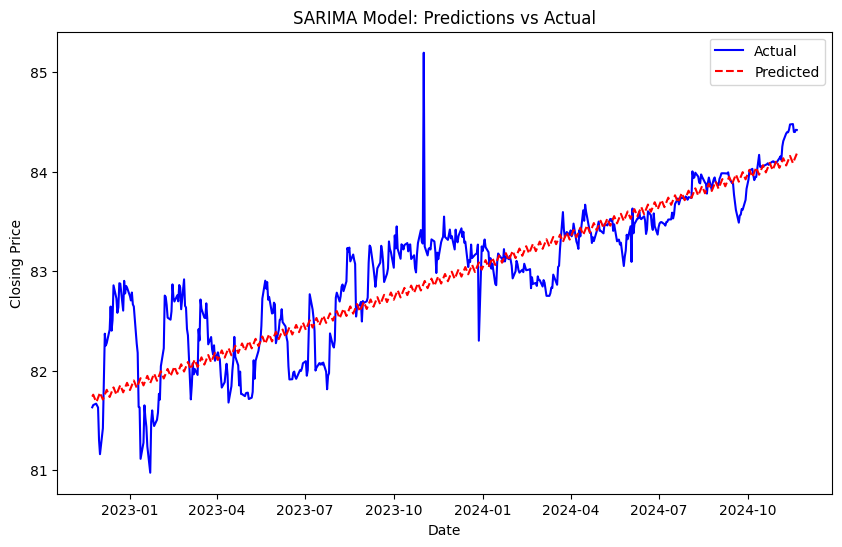

Root Mean Squared Error (RMSE): 0.3763


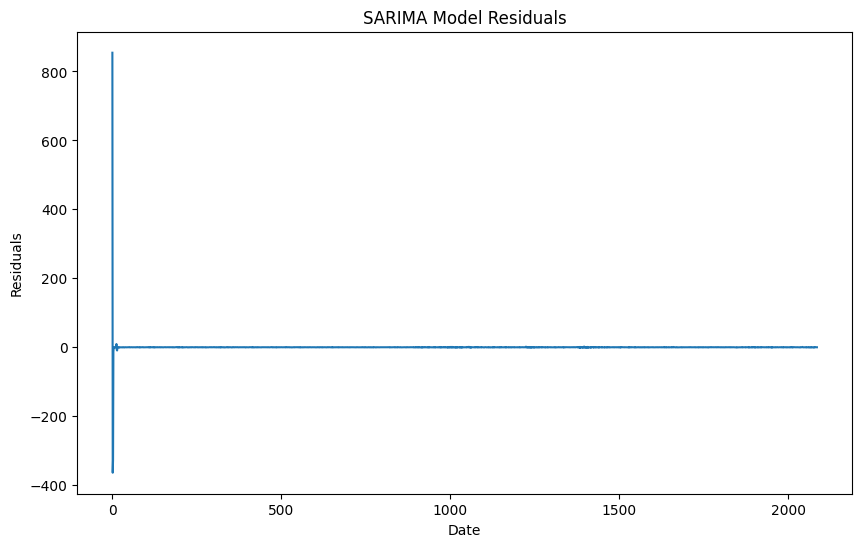

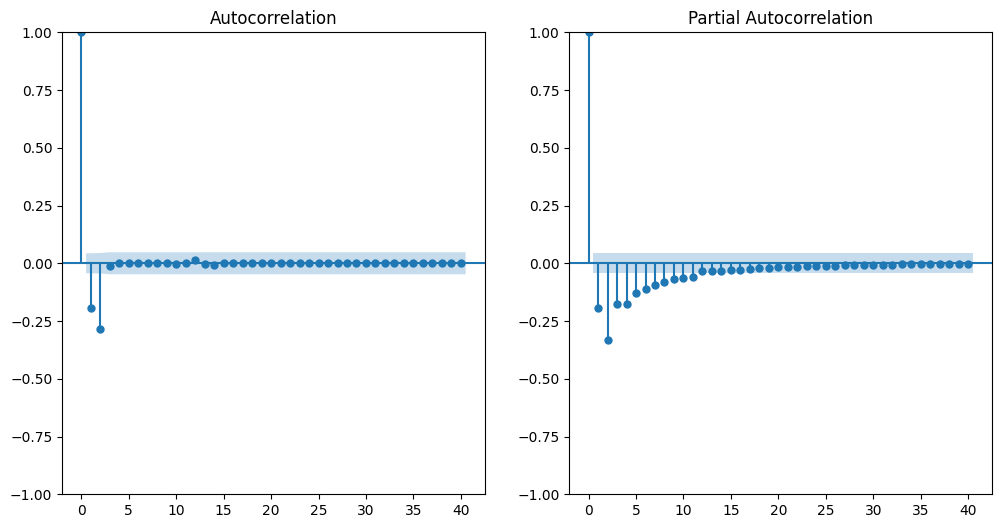

                                      SARIMAX Results                                       
Dep. Variable:                        Closing_price   No. Observations:                 2086
Model:             SARIMAX(2, 2, 2)x(1, 0, [1], 12)   Log Likelihood                -378.659
Date:                              Tue, 26 Nov 2024   AIC                            773.317
Time:                                      14:59:30   BIC                            818.396
Sample:                                           0   HQIC                           789.841
                                             - 2086                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Date_numeric -5.594e-07   1.04e-07     -5.404      0.000   -7.62e-07   -3.57e-07
ar.L1        

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# Ensure 'Date' is in datetime format
usdinrSarima['Date'] = pd.to_datetime(usdinrSarima['Date'])

# Convert 'Date' to numeric (timestamp)
usdinrSarima['Date_numeric'] = usdinrSarima['Date'].apply(lambda x: x.timestamp())

# Define the target column
target = 'Closing_price'

# Train-Test Split (80%-20%)
train_size = int(len(usdinrSarima) * 0.8)
train, test = usdinrSarima[:train_size], usdinrSarima[train_size:]

# Hyperparameters for SARIMA
p, d, q = 2, 2, 2  # AR, I, MA order
P, D, Q, S = 1, 0, 1, 12  # Seasonal AR, I, MA order, and period

# SARIMA Model: SARIMAX for seasonal data
sarima_model = SARIMAX(train[target], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, S), 
                       exog=train[['Date_numeric']],  # Include 'Date_numeric' as an exogenous variable
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the model
sarima_fit = sarima_model.fit()

# Make predictions
predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=test[['Date_numeric']])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], test[target], label="Actual", color='blue')
plt.plot(test['Date'], predictions, label="Predicted", color='red', linestyle="--")
plt.legend()
plt.title("SARIMA Model: Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

# Evaluate the model with RMSE
rmse_val = rmse(test[target], predictions)
print(f"Root Mean Squared Error (RMSE): {rmse_val:.4f}")

# Plot residuals to check for patterns
residuals = sarima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("SARIMA Model Residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Plot ACF and PACF of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.show()

# Optional: Print out model diagnostics
print(sarima_fit.summary())